In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define paths
DATA_PATH_G = "./data/games.csv"
DATA_PATH_T = "./data/teams.csv"
OUTPUT_DIR = "./output"
PLOTS_DIR = "./plots"

In [33]:
games = pd.read_csv(DATA_PATH_G)
teams = pd.read_csv(DATA_PATH_T)

In [35]:
home = games[['SEASON', 'HOME_TEAM_ID', 'PTS_home', 'FG_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']].copy()
home = home.rename(columns={
    'HOME_TEAM_ID': 'TEAM_ID',
    'PTS_home': 'PTS',
    'FG_PCT_home': 'FG_PCT',
    'AST_home': 'AST',
    'REB_home': 'REB',
    'HOME_TEAM_WINS': 'WIN'
})

away = games[['SEASON', 'VISITOR_TEAM_ID', 'PTS_away', 'FG_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS']].copy()
away = away.rename(columns={
    'VISITOR_TEAM_ID': 'TEAM_ID',
    'PTS_away': 'PTS',
    'FG_PCT_away': 'FG_PCT',
    'AST_away': 'AST',
    'REB_away': 'REB'
})

away['WIN'] = 1 - away['HOME_TEAM_WINS']

# Combine home and away data
all_games = pd.concat([home, away], ignore_index=True)

agg_stats = all_games.groupby(['SEASON', 'TEAM_ID']).agg(
    wins=('WIN', 'sum'),
    avg_pts=('PTS', 'mean'),
    avg_fg_pct=('FG_PCT', 'mean'),
    avg_ast=('AST', 'mean'),
    avg_reb=('REB', 'mean')
).reset_index()

agg_stats = agg_stats.merge(teams, on='TEAM_ID', how='left')

X = agg_stats[['avg_pts', 'avg_fg_pct', 'avg_ast', 'avg_reb']]
y = agg_stats['wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 159.00143426599968
Coefficients: [-9.47509859e-01  7.68007218e+02 -2.57370199e-01  2.59987013e+00]
Intercept: -312.2867035048072


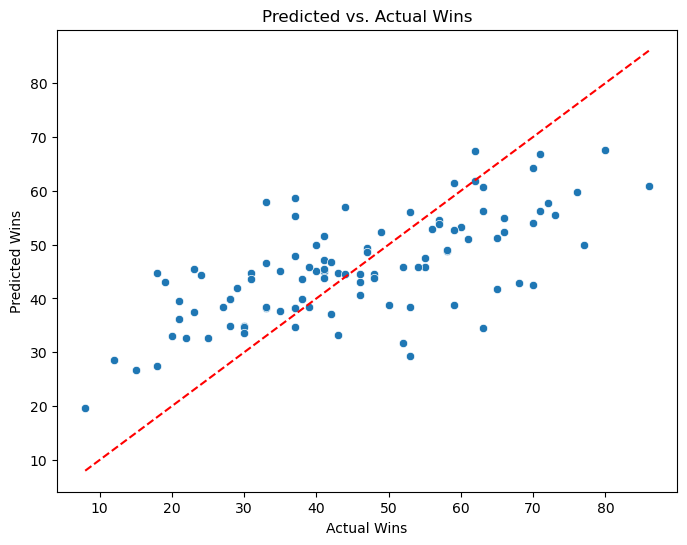

In [36]:
# Assuming y_test contains the actual wins and y_pred the predicted wins from your model
X = y_test, y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Predicted vs. Actual Wins")
# Plot a reference line where predicted equals actual
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [38]:
games = pd.read_csv(DATA_PATH_G)
teams = pd.read_csv(DATA_PATH_T)

In [39]:
games.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [64]:
def split_data(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Splits the dataframe into training, validation, and test sets.
    The test set is test_size fraction of the entire dataset, and 
    the validation set is val_size fraction of the remaining data.
    """
    # Split into train+val and test
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    # Calculate validation size relative to the train+val split
    val_relative_size = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_val_df, test_size=val_relative_size, random_state=random_state)
    
    total = len(df)
    assert abs(len(test_df) - test_size * total) < total * 0.05, "Test set size not as expected"
    assert abs((len(train_df) + len(val_df)) - (1 - test_size) * total) < total * 0.05, "Train+Val set size mismatch"
    
    return train_df, val_df, test_df

In [41]:
def test_split_data():
    """Simple test function to validate split_data."""
    test_df = pd.DataFrame({'A': range(100)})
    train, val, test = split_data(test_df, test_size=0.2, val_size=0.1, random_state=0)
    total = len(train) + len(val) + len(test)
    assert total == 100, "Total rows do not sum to 100"
    print("split_data function passed the test.")

In [61]:
def compute_full_corr_matrix(df, columns_to_use=None, output_path="full_correlation_matrix.csv", 
                            visualize=True, figsize=(12, 10), cmap="coolwarm", 
                            save_fig_path="correlation_heatmap.png"):
    """
    Computes the correlation matrix between selected features.
    Categorical features are one-hot encoded.
    The complete correlation matrix is saved as a CSV.
    Also visualizes the correlation matrix as a heatmap if visualize=True.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing the features
    columns_to_use : list, optional
        Specific columns to include in the correlation matrix
    output_path : str, default="full_correlation_matrix.csv"
        Path where the CSV file will be saved
    visualize : bool, default=True
        Whether to generate and display a heatmap visualization
    figsize : tuple, default=(12, 10)
        Size of the figure for the heatmap
    cmap : str, default="coolwarm"
        Colormap to use for the heatmap
    save_fig_path : str, default="correlation_heatmap.png"
        Path where the heatmap image will be saved
        
    Returns:
    --------
    pandas.DataFrame
        The correlation matrix
    """
    # Use only specified columns if provided
    if columns_to_use:
        df = df[columns_to_use].copy()
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
    # One-hot encode only if necessary and with fewer columns
    if categorical_cols:
        df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        df_encoded = df
    
    # Compute correlation only on numeric columns
    numeric_cols = df_encoded.select_dtypes(include=['number']).columns
    corr_matrix = df_encoded[numeric_cols].corr()
    
    # Save to CSV
    corr_matrix.to_csv(output_path)
    print(f"Full correlation matrix saved to {output_path}")
    
    # Visualize the correlation matrix
    if visualize:
        plt.figure(figsize=figsize)
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Generate a heatmap with seaborn
        heatmap = sns.heatmap(
            corr_matrix,
            annot=True,            # Display the correlation values
            mask=mask,             # Only show lower triangle (avoid redundancy)
            cmap=cmap,             # Color scheme
            vmin=-1, vmax=1,       # Set limits for correlation values
            linewidths=0.5,        # Width of cell borders
            annot_kws={"size": 8}, # Font size for annotations
            fmt=".2f"              # Format for the correlation values (2 decimal places)
        )
        
        plt.title('Correlation Matrix Heatmap', fontsize=16)
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(save_fig_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to {save_fig_path}")
        
        # Show the plot
        plt.show()
    
    return corr_matrix

In [73]:
def plot_scatter_features(df, feature_x, feature_y, output_dir="plots", 
                         transformation_x=None, transformation_y=None, 
                         color_by=None, title=None, figsize=(10, 8)):
    """
    Creates a scatterplot between two specified features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing the features
    feature_x : str
        The name of the feature to plot on the x-axis
    feature_y : str
        The name of the feature to plot on the y-axis
    output_dir : str, default="scatter_plots"
        Directory where the plot will be saved
    transformation_x : function, optional
        A transformation function to apply to the x-axis feature (e.g., np.log1p)
    transformation_y : function, optional
        A transformation function to apply to the y-axis feature
    color_by : str, optional
        Name of a column to use for coloring the points
    title : str, optional
        Custom title for the plot (default will be "feature_x vs feature_y")
    figsize : tuple, default=(10, 8)
        Size of the figure
        
    Returns:
    --------
    str
        Path to the saved plot
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Check if features exist in the dataframe
    if feature_x not in df.columns:
        raise ValueError(f"Feature '{feature_x}' not found in dataframe")
    if feature_y not in df.columns:
        raise ValueError(f"Feature '{feature_y}' not found in dataframe")
    
    plt.figure(figsize=figsize)
    
    # Get data and apply transformations if specified
    x = df[feature_x].copy()
    y = df[feature_y].copy()
    
    x_label = feature_x
    y_label = feature_y
    
    if transformation_x is not None:
        x = transformation_x(x)
        x_label = f"{feature_x} (transformed)"
    
    if transformation_y is not None:
        y = transformation_y(y)
        y_label = f"{feature_y} (transformed)"
    
    # Create the scatter plot
    if color_by and color_by in df.columns:
        scatter = plt.scatter(x, y, c=df[color_by], alpha=0.7, cmap='viridis')
        plt.colorbar(scatter, label=color_by)
    else:
        plt.scatter(x, y, alpha=0.7)
    
    # Add a regression line with confidence interval
    if color_by is None:  # Only add regression line if not coloring by a variable
        sns.regplot(x=x, y=y, scatter=False, line_kws={"color": "red"})
    
    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if title:
        plt.title(title)
    else:
        plt.title(f"Scatter plot of {feature_x} vs {feature_y}")
    
    # Add correlation coefficient as text
    corr = df[[feature_x, feature_y]].corr().iloc[0, 1]
    plt.annotate(f"Correlation: {corr:.3f}", 
                xy=(0.05, 0.95), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Save the plot
    file_name = f"{feature_x}_vs_{feature_y}.png"
    save_path = os.path.join(output_dir, file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Scatter plot saved: {save_path}")
    return save_path

In [74]:
df = pd.read_csv(DATA_PATH_G)

In [79]:
def main():
    test_split_data()
        
    train_df, val_df, test_df = split_data(df, test_size=0.2, val_size=0.1, random_state=42)
    
    print("Making matrix")
    # Select only relevant columns for correlation analysis
    relevant_columns = ['PTS_home', 'FG_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']  # Add your relevant columns
    corr_matrix = compute_full_corr_matrix(df, columns_to_use=relevant_columns)

    plot_scatter_features(df, 'FG_PCT_home', 'PTS_home')
    plot_scatter_features(df, 'AST_home', 'FG_PCT_home')   
    plot_scatter_features(df, 'PTS_home', 'AST_home')
    
    
    print("\nSummary of Learnings:")
    print("1. Feature selection is critical to the performance of linear regression.")
    print("2. Correlation analysis helps identify the most influential predictors.")
    print("3. Transformations may improve the linearity of relationships and model performance.")
    print("4. Even simple models like linear regression can provide insights when the underlying assumptions are met.")



split_data function passed the test.
Making matrix
Full correlation matrix saved to full_correlation_matrix.csv
Correlation heatmap saved to correlation_heatmap.png


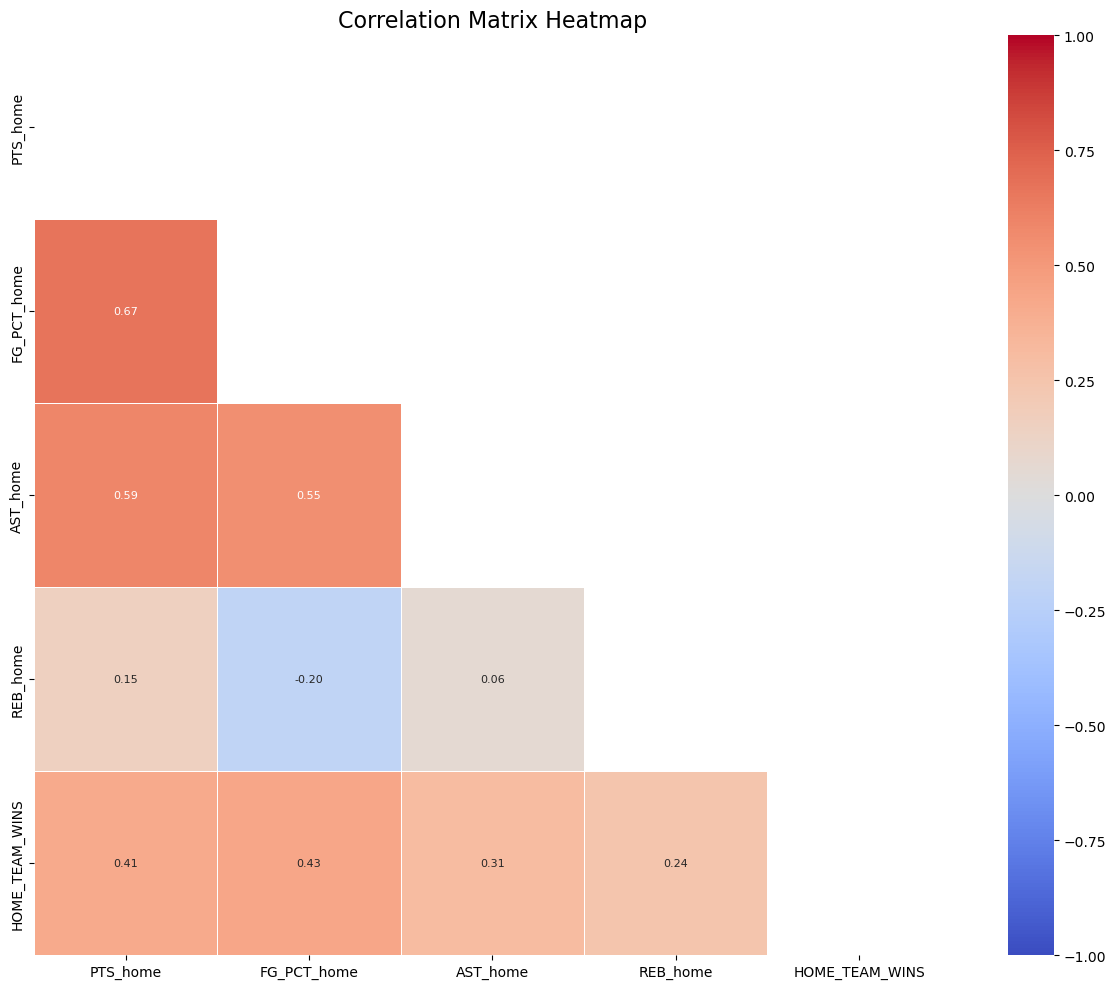

Scatter plot saved: plots/FG_PCT_home_vs_PTS_home.png
Scatter plot saved: plots/AST_home_vs_FG_PCT_home.png
Scatter plot saved: plots/PTS_home_vs_REB_home.png

Summary of Learnings:
1. Feature selection is critical to the performance of linear regression.
2. Correlation analysis helps identify the most influential predictors.
3. Transformations may improve the linearity of relationships and model performance.
4. Even simple models like linear regression can provide insights when the underlying assumptions are met.


In [80]:
if __name__ == "__main__":
    main()